## 1. Import

In [1]:
# Math Packages
import math
import pandas as pd
import numpy as np

# Plot Packages 
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
%matplotlib inline

# Machine Learning Packages
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn import svm
from sklearn import linear_model
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

# NLP Packages
import spacy
nlp = spacy.load('en')
from gensim.models.phrases import Phrases
from gensim.corpora import Dictionary
from gensim.models import LdaMulticore

# Other Packages
import pickle
import imageio
import datetime
#from datetime import *
from wordcloud import WordCloud, STOPWORDS
from statsmodels.tsa.seasonal import seasonal_decompose
import warnings 
warnings.simplefilter('ignore')

In [2]:
# File path
DATA_FOLDER = "./data/"
META_HEALTH_CARE = "health_metadata.pkl"
REVIEWS_HEALTH_CARE = "health_review.pkl"
HEALTH_CARE = "health_merge.pkl"
# Constant parameter
Seed = 0

## 2. Key Words Anylisis of Review

**Defination of [key words](https://en.wikipedia.org/wiki/Keyword_(linguistics) of Review:**

>Keyness is the quality a word has of being "key" in its context. A word has keyness in a certain textual context can be called a key word. 

In general, key words of review are words in review which typically describe some particular topics of the review. In this project, we extract key words of reviews in two ways.

In [3]:
# Prepare the data
df_health_review = pd.read_pickle(DATA_FOLDER + REVIEWS_HEALTH_CARE)
reviews = df_health_review[['asin', 'reviewText']]
reviews['ReviewTime'] = df_health_review['ReviewTime'].map(lambda x: x.year)
reviews.head(5)

,asin,reviewText,ReviewTime
0,0077614992,This book was a requirement for a college clas...,2013
1,0615208479,This is a great gift for anyone who wants to h...,2008
2,0615269990,Very helpful in learning about different disea...,2014
3,0615269990,Occam's Razor is an unbelievably intuitive and...,2013
4,0615269990,I met the guys from Nerdcore at a medical conf...,2014


**2.1 Extract key words according to POS frequency** 

>In corpus linguistics, a [key word](https://en.wikipedia.org/wiki/Keyword_(linguistics) is a word which occurs in a text more often than we would expect to occur by chance alone.

Intuitively, the frequency of words in a review can represent the keyness of words to some extent. However, some very frequent small words([Stop word](https://en.wikipedia.org/wiki/Stop_words)) carry little information and can drown out information contained in real content words.
<br>

Parts-of-speech are categories of words that exhibit similar grammatical properties such as adjectives, adverbs and verbs. To avoid negative effect of stop words, we focus on the frequency of nouns, adjectives, adverbs and verbs in reviews. To be able to identify the Parts-of-speech of word that we will need for our analysis, we use [Spacy](https://spacy.io/usage/) package for Python. Spacy is capable of returning PoS tags for any given word. 


**Method**:<br>
We are going to find nouns, verbs, adverbs, and adjectives in reveiws of **health care products** of **each year**.
- Group reviews by year and focus reviews of each year.
2. Tokenization: Maps reviews into sequence of tokens.
3. Lemmatization: Transform all forms of words into original form, e.g. transform 'went' and 'goes' into 'go' using `.lemma_` attribute of tokens.
4. Select only nouns, verbs, adverbs, and adjectives using `.pos_` attribute of tokens.

In [4]:
def get_POS(reviews):
    '''
        Get nouns, adjectives, adverbs and verbs in reviews of each year.
    '''
    # Load general stop words in Spacy package
    STOPWORDS = spacy.lang.en.stop_words.STOP_WORDS
    keywords_year_dict = {}
    # Consider POS of reviews of each year
    grouped_year = reviews.groupby('ReviewTime')
    for name, group in grouped_year:
        nouns = []
        verbs = []
        advs = []
        adjs = []
        for doc in group.reviewText:
            # Tokenization
            doc = nlp(doc)
            # Distract NOUN, VERB, ADV, ADJ of reviews and turn their lemmas
            for token in doc:
                # Removing stop words, like 'my','I',etc
                if not token.is_stop and token.text not in STOPWORDS:
                    if token.pos_ == "NOUN":
                        nouns.append(token.lemma_)
                    if token.pos_ == "VERB":
                        verbs.append(token.lemma_)
                    if token.pos_ == "ADV":
                        advs.append(token.lemma_)
                    if token.pos_ == "ADJ":
                        adjs.append(token.lemma_)
        # Zip POS of reviews of each year in a dictionary
        keywords_year_dict.update({str(name):{"NOUN":nouns, "VERB": verbs, "ADV": advs, "ADJ": adjs}})
    return keywords_year_dict

In [5]:
# ---------- get POS of reviews of each year and save ---------- #
# keywords_year_dict = get_POS(reviews.sample(frac=0.1, random_state=Seed))
# with open('keywords_year_dict.pickle', 'wb') as handle:
#     pickle.dump(keywords_year_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('keywords_year_dict.pickle', 'rb') as handle:
    keywords_year_dict = pickle.load(handle)

**Visualization:**

A [word cloud](https://en.wikipedia.org/wiki/Tag_cloud) is a visual representation of text data, typically used to depict keyword metadata (tags) on websites, or to visualize free form text.We use `WordCloud` function from [**wordcloud**](https://amueller.github.io/word_cloud/index.html) package to draw wordcloud for each year.

We firstly plot data of year 2013 as an example, then analyze each year in detail.

In [6]:
def draw_wordcloud(keyword_list, stopword, mask, top_word_num = 10):
    '''
        Draw the wordcloud of key words and legend top words in them.
    '''
    # Create wordcloud 
    wordcloud = WordCloud(background_color='white',
                          mask=mask,
                          collocations=False, 
                          stopwords=stopword, 
#                           colormap="Set2_r",
                          max_words=1000,
                          max_font_size=200).generate(" ".join(keyword_list))
    plt.imshow(wordcloud)
    # Set legend option and put a legend to the right of the current axis
    colors = []
    words = []
    for element in wordcloud.layout_[0:top_word_num]:
        ((word,freq),size,pos,orientation,color) = element
        color = tuple(map(lambda x:int(x)/255, color.strip('rgb(').strip(')').split(',')))
        colors.append(color)
        words.append(word)
    patches = []
    for i in range(top_word_num):
        patches.append(mpatches.Patch(color=colors[i], label=words[i]))
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5),handles=patches)
    
    plt.axis("off")

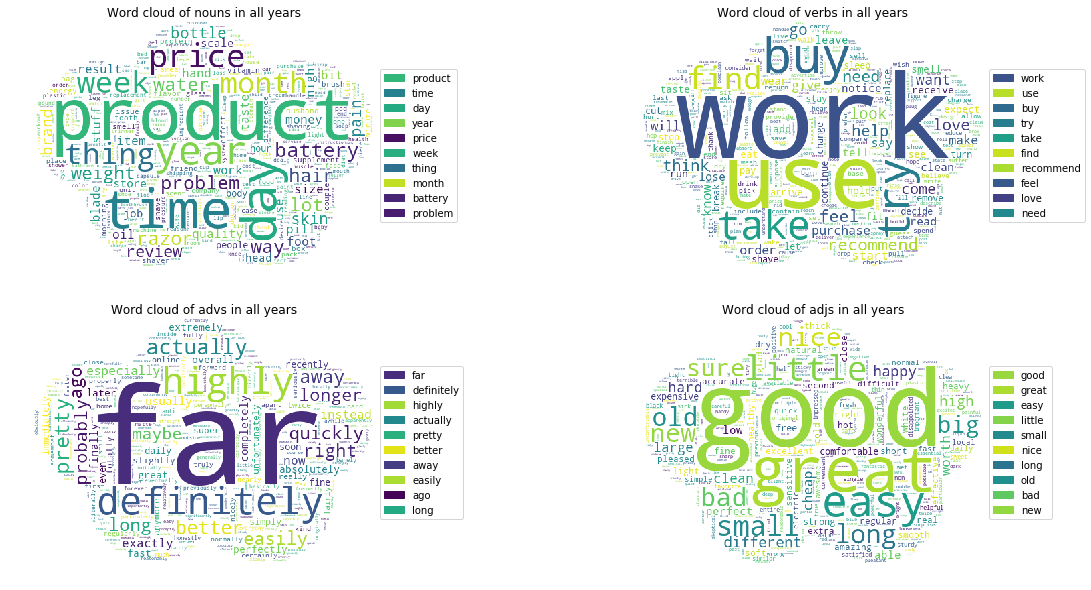

In [7]:
# Key words of all years
top_word_num = 10
# Filiter '-PRON-' in POS of reviews
del_word = ['PRON']
stopword = STOPWORDS|set(del_word)
picture = imageio.imread('mask-cloud.png')

POS_LIST = ['NOUN', 'VERB', 'ADV', 'ADJ']
fig = plt.figure(figsize=(20,10))
for i, POS in enumerate(POS_LIST):
    plt.subplot(2, 2, i+1)
    keyword_all_year = []
    for j in keywords_year_dict.keys():
        keyword_all_year.extend(keywords_year_dict[j][POS])
    draw_wordcloud(keyword_all_year, stopword, picture, top_word_num)
    plt.title('Word cloud of ' + POS.lower() + 's in all years')
plt.show()

⬆From the figures above, we know that:
1. Top words in nouns are words that describe common attributes of all kinds of products such as 'product', 'price', 'time', which do not offer any explicit aspect of health care products. So as verbs, which are not very informative. 
2. We can see that in key words of all years, positive words such as 'good', 'great', 'easy', 'nice' have a high probability in adjectives. Although negative words such as 'bad', 'old' also occupy a high probability, they are obviously lower than positive words. Roughly, it means reviews on health care products in these years are mainly positive.

--------------

**2.2 Key Words Changing Over Year** 

Adjectives alone are a good and imformative way of quickly extracting an impression on a product. So we use ajectives to represent the changing of key words over years.

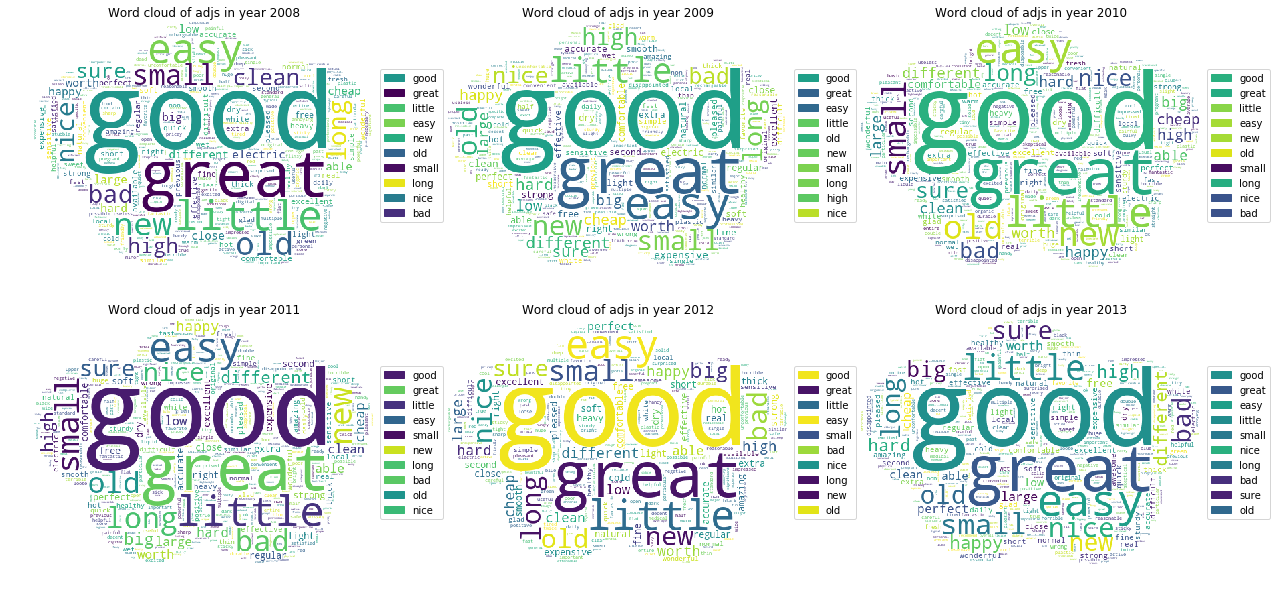

In [8]:
# We use ajectives to represent the changing of key words over years.
Year_LIST = ['2008', '2009', '2010', '2011', '2012', '2013']
fig = plt.figure(figsize=(21,10))
for i, year in enumerate(Year_LIST):
    plt.subplot(2, 3, i+1)
    keyword_list = keywords_year_dict[year]['ADJ']
    draw_wordcloud(keyword_list, stopword, picture, top_word_num)
    plt.title('Word cloud of adjs in year ' + year)
plt.show()

⬆From the figures above, we can know that:
1. From year 2008 to 2013, the top10 key words of health care products in adjectives remain quite stable, which are 'good', 'great', 'little', 'easy', 'new', 'old', 'small', 'long', 'nice', 'bad' but in different order (relative frequency) in different years.
2. The key words 'good' and 'great' are dominant in every year which have a much higher probability than word 'bad'. To some extent, we can make a conclusion that the key words of health care products change slightly and always have a relatively positive evaluation in these years.

--------------

**2.3 Analyze collocations of words**

- Sometimes single word can not describe attributes of product explicitly. For example, suppose that we receive multiple times the adjective 'good', we are not sure what exactly is considered by the users as good in this product. Is it the price or its performances? We therefore also want to analyze **collocations of words**.

**Method**:<br>
- Tokenize reviews, Lemmatize tokens and remove stop words.
- Use `gensim.models.phrases` module in [gensim](https://radimrehurek.com/gensim/) library to get collocations (big of word) of words.  

In [9]:
def get_bigram(docs, min_count):
    '''
        Add bigrams to docs (only ones that appear min_count times or more).
    '''
    bigram_list = []
    bigram = Phrases(docs, min_count)
    for idx in range(len(docs)):
        bigram_word = []
        for token in bigram[docs[idx]]:
            if '_' in token:
                # Token is a bigram, add to document.
                bigram_word.append(token)
        bigram_list.append(bigram_word)
    return bigram_list

In [10]:
def analyze_bigram(reviews):
    docs_year_dict = {}
    # A set of stopwords
    STOPWORDS = spacy.lang.en.stop_words.STOP_WORDS
    grouped_year = reviews.groupby('ReviewTime')
    for name, group in grouped_year:
        # Put all reviews in a year to a list
        docs = []
        for review in group.reviewText:
            # NLP analyze and get a Spacy object
            doc = nlp(review)
            # Lemmatize tokens, Keep only words and remove stopwords.
            doc = [token.lemma_ for token in doc if token.is_alpha and not token.is_stop]
            # Remove common words from a stopword list and keep only words of length 3 or more.
            doc = [token for token in doc if token not in STOPWORDS and len(token) > 2]
            docs.append(doc)
        # get bigrams to docs (only ones that appear 2 times or more).
        docs = get_bigram(docs, 2)
        extend_docs = []
        for bigram_word in docs:
            extend_docs.extend(bigram_word)
        docs_year_dict.update({str(name):extend_docs})   
    return docs_year_dict

In [11]:
# bigram_year_dict = analyze_bigram(reviews.sample(frac=0.1, random_state=Seed))
# # ---------- get data and save ---------- #
# with open('bigram_year_dict.pickle', 'wb') as handle:
#     pickle.dump(bigram_year_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('bigram_year_dict.pickle', 'rb') as handle:
    bigram_year_dict = pickle.load(handle)

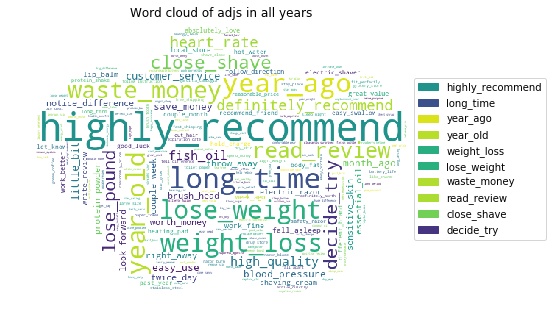

In [12]:
fig = plt.figure(figsize=(16,5))
keyword_all_year = []
for i in bigram_year_dict.keys():
    keyword_all_year.extend(bigram_year_dict[i])
draw_wordcloud(keyword_all_year, stopword, picture, top_word_num)
plt.title('Word cloud of bigrams in all years')
plt.show()

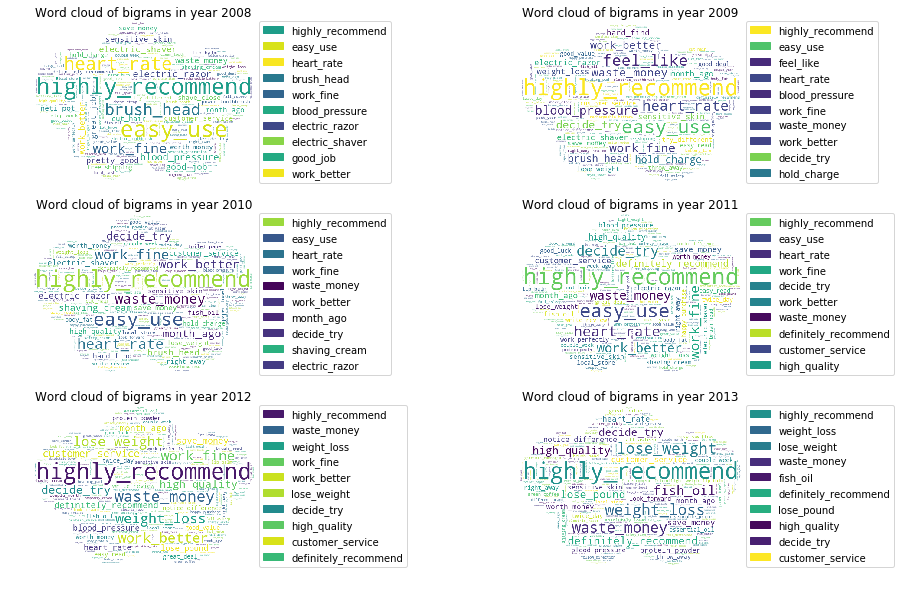

In [13]:
del_word = ['long_time', 'year_ago', 'year_old', 'little_bit', 'close_shave', 'read_review']
stopword = STOPWORDS|set(del_word)
picture = imageio.imread('mask-cloud.png')
top_word_num = 10
# Plot bigrams over years
Year_LIST = ['2008', '2009', '2010', '2011', '2012', '2013']
fig = plt.figure(figsize=(16,10))
for i, year in enumerate(Year_LIST):
    plt.subplot(3, 2, i+1)
    keyword_list = bigram_year_dict[year]
    draw_wordcloud(keyword_list, stopword, picture, top_word_num)
    plt.title('Word cloud of bigrams in year ' + year)
plt.show()

⬆From the figures above, we can know that:
1. If we foucs on bigrams in reviews, we get a outcome quite different from that we get when we only analyze a single part-of-speech above(e.g. adjectives). We find that the words with high probability in adjectives like 'good', 'great' almost disappear, and bigrams with 'adj-noun' structure occur much less than those with 'adv-verb', 'noun-noun' structures.
2. From 2008 to 2013, **'highly recommend'** always has the highest frequency among all bigrams and it can naturally be regarded as a positive bigram. Although negative bigram like **'waste money'** also has a top 10 probability in bigrams, its probability is much lower. So, roughly, we can say that health care products always have a positive evaluation in general and keep popular over these year.
3. We find a interesting phenomenon that **'heart rate'** occurs frequently from 2008 to 2011, however, it disappears from top 10 key bigrams after 2012. At the same time, **'lose weight'** gets more popular and becomes a top 10 key bigram after 2012. From this phenomenon, we may find that people pay more attention to their appearance than before, they are more willing to buy health care products to build a slim figure.

--------------

In [14]:
def interested_day(df,month,day):
    # a week
    df['month-day'] = df['ReviewTime'].apply(lambda x: x.strftime('%m-%d'))
    date = datetime.datetime.strptime(str(month)+'-'+str(day),"%m-%d")
    delta = datetime.timedelta(days=7)
    
    date_period = (date+delta).strftime('%m-%d')
    date_period_month = (date+delta).strftime('%m')
    date_start  = date.strftime('%m-%d')
    date_start_month  = date.strftime('%m')
    
    
    if date_start_month <= date_period_month:
        interested_day = df[(df['month-day']<date_period)&(df['month-day']>=date_start)]
    else:
        interested_day = df[((df['month-day']>=date_start))&(df['month-day']<='12-31')|(df['month-day']<date_period)]
    return interested_day

In [16]:
interest_day = interested_day(df_health_review, 12, 25)

In [19]:
interest_day.reviewText.iloc[0:10]

19     Started using electric cord at home and within...
96     I love this thing.  I gave it 4 stars because ...
98     Susan has a realistic way of bringing optimism...
103    You know, dropping $73 for this book was not s...
209    These gift tags are very pretty but it would b...
210    Cavallini never disappoints me. I love their p...
219    It does not  lay flat........its looks cheap.....
235    These remind me of the vintage cards I got as ...
320    This paper tape set is one of my favorites. I ...
338    cards were very cute, same with tin and sticke...
Name: reviewText, dtype: object

In [26]:
STOPWORDS = spacy.lang.en.stop_words.STOP_WORDS
keywords_christmas_dict = {}
nouns = []
verbs = []
advs = []
adjs = []
for doc in interest_day.reviewText:
    # Tokenization
    doc = nlp(doc)
    # Distract NOUN, VERB, ADV, ADJ of reviews and turn their lemmas
    for token in doc:
        # Removing stop words, like 'my','I',etc
        if not token.is_stop and token.text not in STOPWORDS:
            if token.pos_ == "NOUN":
                nouns.append(token.lemma_)
            if token.pos_ == "VERB":
                verbs.append(token.lemma_)
            if token.pos_ == "ADV":
                advs.append(token.lemma_)
            if token.pos_ == "ADJ":
                adjs.append(token.lemma_)
keywords_christmas_dict.update({"NOUN":nouns, "VERB": verbs, "ADV": advs, "ADJ": adjs})
keywords_christmas_dict

{'NOUN': ['cord',
  'home',
  'month',
  'base',
  'cord',
  'clip',
  'light',
  'part',
  'light',
  'thing',
  'star',
  'way',
  'paper',
  'thing',
  'way',
  'optimism',
  'table',
  'part',
  'cancer',
  'cancer',
  'choice',
  'book',
  'perspective',
  'idea',
  'battle',
  'cancer',
  'life',
  'moment',
  'thing',
  'victor',
  'life',
  'happiness',
  'situation',
  'wisdom',
  'undercurrent',
  'smile',
  'book',
  'e',
  'book',
  'appeal',
  'version',
  'quality',
  'paper',
  'chemical',
  'diagram',
  'notation',
  'reason',
  'hardcover--',
  'bc',
  'hardcover',
  'quality',
  'book',
  'quality',
  'dollar',
  'book',
  'today',
  'paper',
  'quality',
  'phone',
  'book',
  'garbage',
  'computer',
  'paper',
  '100x',
  'quality',
  'newspaper',
  'horrid',
  'deal',
  'cover',
  'note',
  'margin',
  'diagram',
  'none',
  'page',
  'quality',
  'newspaper',
  'hamster',
  'cage',
  'day',
  'ploy',
  'people',
  'page',
  'them--',
  'geniuses--',
  'trouble',


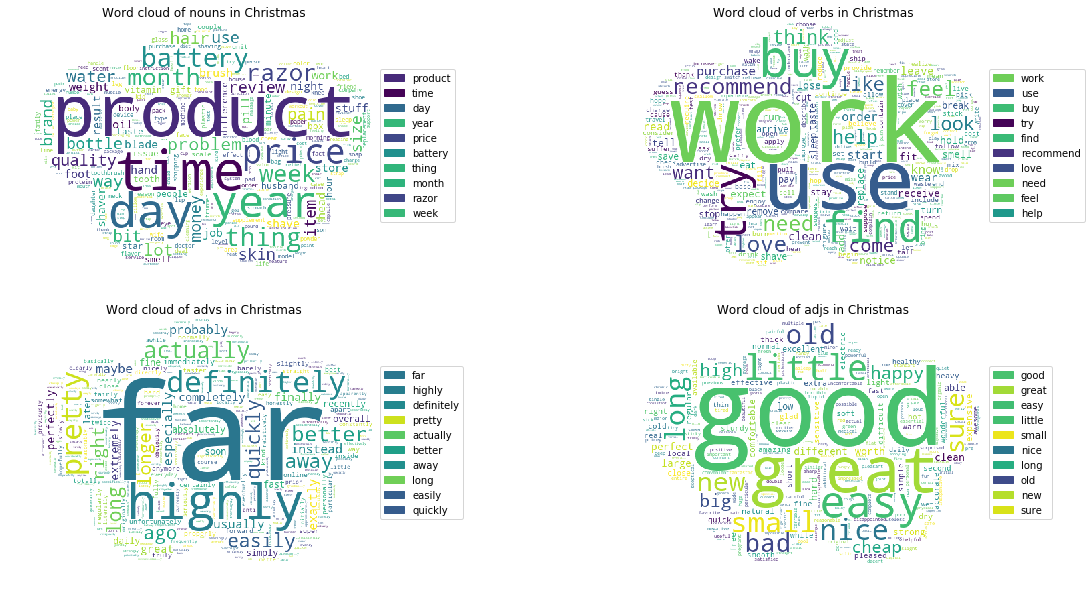

In [31]:
# Key words of all years
top_word_num = 10
# Filiter '-PRON-' in POS of reviews
del_word = ['PRON']
stopword = STOPWORDS|set(del_word)
picture = imageio.imread('mask-cloud.png')

POS_LIST = ['NOUN', 'VERB', 'ADV', 'ADJ']
fig = plt.figure(figsize=(20,10))
for i, POS in enumerate(POS_LIST):
    plt.subplot(2, 2, i+1)
    draw_wordcloud(keywords_christmas_dict[POS], stopword, picture, top_word_num)
    plt.title('Word cloud of ' + POS.lower() + 's in Christmas')
plt.show()

In [27]:
STOPWORDS = spacy.lang.en.stop_words.STOP_WORDS
bigrams_christmas_dict = {}
docs = []
for doc in interest_day.reviewText:
    # Tokenization
    doc = nlp(doc)
    # Lemmatize tokens, Keep only words and remove stopwords.
    doc = [token.lemma_ for token in doc if token.is_alpha and not token.is_stop]
    # Remove common words from a stopword list and keep only words of length 3 or more.
    doc = [token for token in doc if token not in STOPWORDS and len(token) > 2]
    docs.append(doc)
# get bigrams to docs (only ones that appear 2 times or more).
docs = get_bigram(docs, 2)
extend_docs = []
for bigram_word in docs:
    extend_docs.extend(bigram_word)
extend_docs

['electric_cord',
 'vertical_horizontal',
 'super_excited',
 'cancer_cancer',
 'high_quality',
 'big_deal',
 'read_book',
 'shame_amazon',
 'gift_tag',
 'recipient_love',
 'lie_flat',
 'add_bonus',
 'highly_recommend',
 'lay_flat',
 'tuck_away',
 'work_wonderfully',
 'gift_card',
 'non_pharmaceutical',
 'sleep_aid',
 'read_review',
 'agree_reviewer',
 'relatively_quickly',
 'star_rating',
 'healing_process',
 'highly_recommend',
 'pharmacy_carry',
 'fall_apart',
 'sore_muscle',
 'arthritic_pain',
 'temporary_relief',
 'joint_ache',
 'highly_recomm',
 'year_old',
 'grand_daughter',
 'like_charm',
 'worth_effort',
 'value_money',
 'ship_quickly',
 'fraction_price',
 'enjoy_herbalife',
 'burn_fat',
 'young_child',
 'share_friend',
 'absolutely_love',
 'compare_similar',
 'battery_life',
 'rechargeable_battery',
 'wal_mart',
 'old_nicd',
 'work_fine',
 'recent_trip',
 'afternoon_evening',
 'rechargeable_battery',
 'recharge_battery',
 'hold_charge',
 'set_aside',
 'nimh_battery',
 'sanyo_e

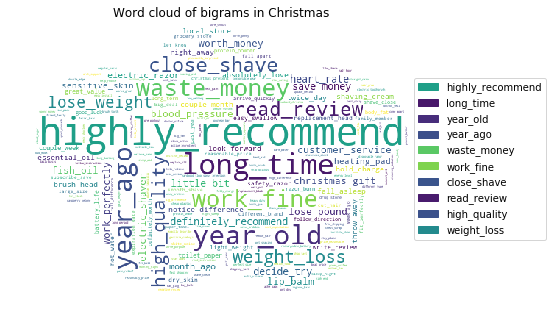

In [33]:
fig = plt.figure(figsize=(16,5))
top_word_num = 10
draw_wordcloud(extend_docs, stopword, picture, top_word_num)
plt.title('Word cloud of bigrams in Christmas')
plt.show()

**2.4 Recommend a category (second category) of Health care products**

We are going to recommend a category (second category) of Health care products according to the **need (product description)** of the consumer. We create a bag of word and apply supervised (SVM) machine learning method to realize this recommendation function.

**Method**:<br>
- Tokenize reviews, lemmatize tokens. Keep only words and remove stop words.
- Create the bag of word of all reviews, turn each review to a word vector and use a sparse matrix to store the word vectors of all reviews. Label each review according to their second category.
- Use SVM machine learning method to train a multi-classification model.
- Give consumer's need (product description), classify it to one class and then recommend this category of health care product to consumer.

In [18]:
# Parpare data: split the category into several sub-categories
df_health_merge_review = pd.read_pickle(DATA_FOLDER + HEALTH_CARE)

health_category = df_health_merge_review.categories.apply(lambda x : x[0]).values.tolist()
df_health_category = pd.DataFrame(health_category)
df_health_category.columns = ['1st','2nd','3rd','4th','5th','6th','7th']

df_health_category['asin'] = df_health_merge_review.asin
df_health_category['overall'] = df_health_merge_review.overall
df_health_category['ReviewTime'] = df_health_merge_review.ReviewTime
df_health_category['reviewText'] = df_health_merge_review.reviewText
df_health_category['title'] = df_health_merge_review.title
df_health_category.drop(columns=['3rd','4th','5th','6th','7th'], inplace=True)
df_health_category.head()

,1st,2nd,asin,overall,ReviewTime,reviewText,title
0,Health & Personal Care,None,0077614992,5.0,2013-02-15,This book was a requirement for a college clas...,Principles of Mgmt + Oper-CSUF Custom C
1,Health & Personal Care,Personal Care,0615208479,5.0,2008-12-01,This is a great gift for anyone who wants to h...,Brain Fitness Exercises Software
2,Health & Personal Care,Personal Care,0615269990,5.0,2014-04-06,Very helpful in learning about different disea...,Occam's Razor
3,Health & Personal Care,Personal Care,0615269990,5.0,2013-12-04,Occam's Razor is an unbelievably intuitive and...,Occam's Razor
4,Health & Personal Care,Personal Care,0615269990,2.0,2014-04-24,I met the guys from Nerdcore at a medical conf...,Occam's Razor


In [8]:
def get_bag_of_word(reviews):
    # A set of stopwords
    STOPWORDS = spacy.lang.en.stop_words.STOP_WORDS
    # Group reviews by 2nd category
    grouped_asin = reviews.groupby('2nd')
    docs = []
    Y = []
    for i, (asin, group) in enumerate(grouped_asin):
        # Put all reviews in one category to a list
        for review in group.reviewText:
            # NLP analyze and get a Spacy object
            doc = nlp(str(review))
            # Lemmatize tokens, Keep only words and remove stopwords.
            doc = [token.lemma_ for token in doc if token.is_alpha and not token.is_stop]
            # Remove common words from a stopword list and keep only words of length 3 or more.
            doc = [token for token in doc if token not in STOPWORDS and len(token) > 2]
            doc = " ".join(doc)
            docs.append(doc)
            Y.append(i)
    # Create bag of words features
    vectorizer = CountVectorizer()
    X = vectorizer.fit_transform(docs)
    return X, Y

In [5]:
# X, Y = get_bag_of_word(df_health_category.sample(frac=0.1, random_state=Seed))
# # ---------- get data and save ---------- #
# with open('SVM_X.pickle', 'wb') as handle:
#     pickle.dump(X, handle, protocol=pickle.HIGHEST_PROTOCOL)
# with open('SVM_Y.pickle', 'wb') as handle:
#     pickle.dump(Y, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('SVM_X.pickle', 'rb') as handle:
    X = pickle.load(handle)
with open('SVM_Y.pickle', 'rb') as handle:
    Y = pickle.load(handle)

In [6]:
# Construct sklearn pipe line to process data
def svm_classification(X, Y):
    # TF-idf
    transformer = TfidfTransformer(smooth_idf=False)
    X = transformer.fit_transform(X)
    #shuffle the data
    X, Y = shuffle(X, Y, random_state=0)
    #split into training and test set
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=1)
    clf = svm.SVC(gamma=0.0001)
    clf.fit(X_train, Y_train)
#     scores = cross_val_score(clf, X_train,Y_train, cv=10)
#     print(scores)
    return clf.score(X_test, Y_test)

In [ ]:
svm_classification(X, Y)

In [11]:
X, Y = get_bag_of_word(df_health_category.iloc[0:100])
svm_classification(X, Y)

0.6666666666666666

--------------

In [204]:
# Create a new DataFrame for review time and the number of reveiw 
df_reviewtime_reveiwnum = df_health_review.groupby('ReviewTime').count()[['asin']]
df_reviewtime_reveiwnum.columns = ['ReviewNumber']
df_reviewtime_reveiwnum = df_reviewtime_reveiwnum.reset_index()

In [205]:
flag = df_reviewtime_reveiwnum['ReviewTime'].map(lambda x: (x.year>2003)&((x.year<2014)))
df_reviewtime_reveiwnum_subset = df_reviewtime_reveiwnum.loc[flag]
df_reviewtime_reveiwnum_subset.head()

,ReviewTime,ReviewNumber
832,2004-01-01,14
833,2004-01-02,6
834,2004-01-03,5
835,2004-01-04,10
836,2004-01-05,14


In [206]:
def plot_seasonal_decomposition(df_reviewtime_reveiwnum_subset, seasonal_decomposition_list, title_list, ylabel_list):
    '''
         Plot seasonal decomposition figures: 
         Initial Time Series Figure, Trend Component Figure, Seasonal Component Figure.
    '''
    for i in range(3):
        plt.subplot(3,1,i + 1)
        plt.plot(df_reviewtime_reveiwnum_subset.ReviewTime, seasonal_decomposition_list[i])
        plt.xlabel('Date')
        plt.ylabel(ylabel_list[i])
        plt.title(title_list[i])
        plt.legend(['Data Change Line'])
    plt.show()

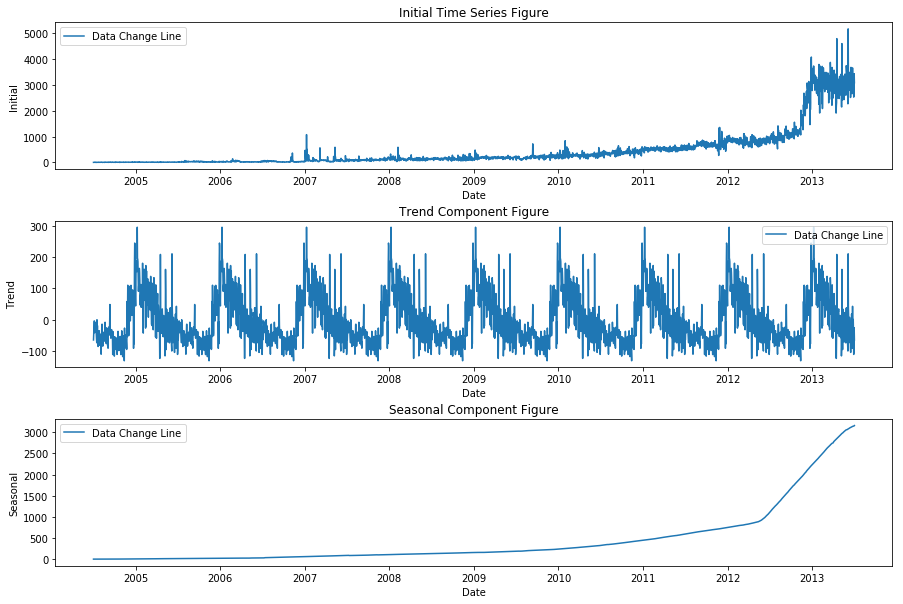

In [220]:
seasonal_decomposition = seasonal_decompose(df_reviewtime_reveiwnum_subset.ReviewNumber,freq=365)

# ---------- Prepare the input data ---------- #
not_null_index = seasonal_decomposition.trend.isnull().map(lambda x: not x)
# Drop null data in seasonal decomposition
observed_data = seasonal_decomposition.observed[not_null_index]
seasonal_data = seasonal_decomposition.seasonal[not_null_index]
trend_data = seasonal_decomposition.trend[not_null_index]
resid_data = seasonal_decomposition.resid[not_null_index]
trend_time = df_reviewtime_reveiwnum_subset[not_null_index]

# ---------- Plot seasonal decomposition ---------- #
fig = plt.figure(figsize=(15,10))
fig.subplots_adjust(hspace=0.35)
title_list = ['Initial Time Series Figure', 'Trend Component Figure', 'Seasonal Component Figure']
ylabel_list = ['Initial', 'Trend', 'Seasonal']
seasonal_decomposition_list = [observed_data, seasonal_data, trend_data, resid_data]
plot_seasonal_decomposition(trend_time, seasonal_decomposition_list, title_list, ylabel_list)

⬆From the figures above, we know that:
1. There is a remarkable increasing trend of review number and the growth rate is becoming more and more faster with the years.
2. There exists a yearly seasonal trend, which starts to grow from November, reaches its peaks around January and then  drops to its lowest point around June.
3. We infer that the growth of review (consumption) is stimulated by Christmas. People may tend to buy more health care products and sent them to their friends or relatives as gifts, which significantly boost the consumption. While after Christmas, the need of health care products gradually falls back.

**Predict trend of review quantity (popularity)**

The review quantity can reflect popularity of the products. From `Initial Time Series Figure` above, we can easily know the changing of review quantity over time. According to the review data we already have, we hope to give a prediction of the future review quantity, namely the trend of popularity of health care products.

**Method**:<br>
- Use `sklearn.preprocessing.PolynomialFeatures` function to generate a new feature matrix consisting of all polynomial combinations of the features(i.e. time).
- Use **ridge regression model** to perform a linear regession. Take 95% `trend` component data as training set to fit the model and tune hyperparameter by cross-validation. Use the left 5% data as test set to test the performance of the model.
- Predict feture trend in one year (2013-7-2 to 2014-7-2). Adding `seasonal` component and combining `residual` component, we can predict a range of review quantity over time.

In [228]:
trend_time_series = trend_time['ReviewTime']
time_timestamp = trend_time['ReviewTime'].map(lambda x: int(x.timestamp()))
# Polynomial combinations of the features
X = time_timestamp.values.reshape(-1,1) / 3600 / 24
poly = PolynomialFeatures(6)
X_poly = poly.fit_transform(X)
Y = trend_data.values.reshape(-1,1)
# Take 95% trend component data as training set, 5% as test set
X_train = X_poly[:int(0.95*X.shape[0])]
Y_train = Y[:int(0.95*Y.shape[0])]
X_test = X_poly[int(0.95*X.shape[0]):]
Y_test = Y[int(0.95*Y.shape[0]):]
# Fit the model and tune hyperparameter by cross-validation
reg = linear_model.RidgeCV(alphas=np.linspace(1,15,5000), cv=10)
reg.fit(X_train, Y_train)
# Use the test set to test the performance of the model
print('Coefficient of determination R^2 of the prediction:', reg.score(X_test, Y_test))
print('The value of hyperparameter alpha:', reg.alpha_)

Coefficient of determination R^2 of the prediction: 0.767588463569373
The value of hyperparameter alpha: 2.996799359871974


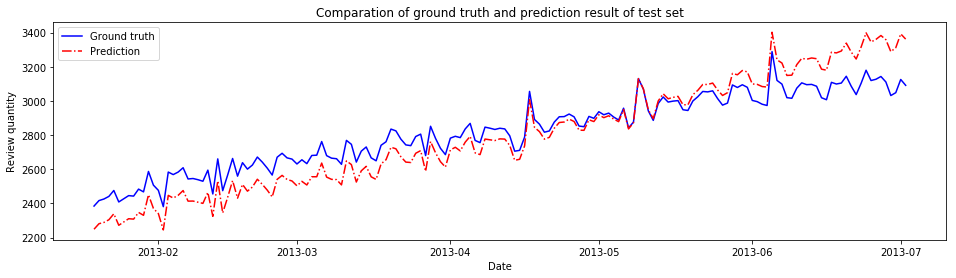

In [257]:
# Plot test result 
plt.figure(figsize=(16,4))
plt.plot(trend_time_series[int(0.95*X.shape[0]):], 
         observed_data[int(0.95*X.shape[0]):] - resid_data[int(0.95*X.shape[0]):], 
         'b-',
         trend_time_series[int(0.95*X.shape[0]):], 
         (reg.predict(X_test).squeeze() + seasonal_data.values[int(0.95*X.shape[0]):]), 
         'r-.')
plt.xlabel('Date')
plt.ylabel('Review quantity')
plt.title('Comparation of ground truth and prediction result of test set')
plt.legend(['Ground truth', 'Prediction'])
plt.show()

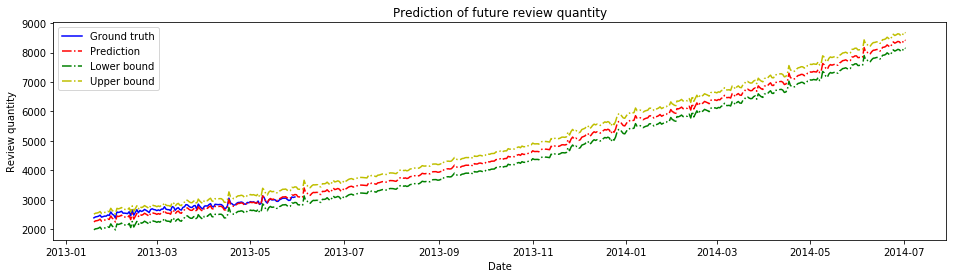

In [258]:
# Predict feture trend in one year (2013-7-2 to 2014-7-2)
last_day = trend_time_series[int(0.95*X.shape[0]):].iloc[-1]
time_predict = np.array([last_day + pd.to_timedelta(i,unit="D") for i in range(1, 366)])
time_exist = np.array(list(map(lambda x: pd.to_datetime(x), trend_time_series[int(0.95*X.shape[0]):].values)))
time_whole = np.concatenate((time_exist, time_predict), axis = 0)

time_whole_X = pd.Series(time_whole)
time_whole_X = time_whole_X.map(lambda x: int(x.timestamp()))
time_whole_X = time_whole_X.values.reshape(-1,1) / 3600 / 24
time_whole_X_poly = poly.fit_transform(time_whole_X)
# Use concepts in box plot, get upper and lower quartiles of residual component
d = resid_data.describe()
IQR = d['75%'] - d['25%']
low_error, high_error = (d['25%'] - 1.5 * IQR, d['75%'] + 1.5 * IQR)
# Set upper and lower quartiles as of residual component as bounds, we indict a region of future trend
upper_resid_bound = reg.predict(time_whole_X_poly).squeeze() + seasonal_data_predict + high_error
lower_resid_bound = reg.predict(time_whole_X_poly).squeeze() + seasonal_data_predict + low_error
# Plot prediction result
plt.figure(figsize=(16,4))
time_exist = np.array(list(map(lambda x: pd.to_datetime(x), trend_time_series[int(0.95*X.shape[0]):int(0.99*X.shape[0])].values)))
seasonal_data_predict = np.concatenate((seasonal_data.values[int(0.95*X.shape[0]):], seasonal_data[-365:]))
plt.plot(time_exist, observed_data[int(0.95*X.shape[0]):int(0.99*X.shape[0])] - resid_data[int(0.95*X.shape[0]):int(0.99*X.shape[0])], 'b')
plt.plot(time_whole, (reg.predict(time_whole_X_poly).squeeze() + seasonal_data_predict), 'r-.')

# Plot bounds
plt.plot(time_whole, lower_resid_bound, 'g-.')
plt.plot(time_whole, upper_resid_bound, 'y-.')

plt.xlabel('Date')
plt.ylabel('Review quantity')
plt.title('Prediction of future review quantity')
plt.legend(['Ground truth', 'Prediction', 'Lower bound', 'Upper bound'])
plt.show()

⬆From the figure above, we can predict that:
1. The review quantity will significantly increase in one year.
2. The review quantity will fluctuate around `Prediction` line and be bounded in `Upper bound` and `Lower bound` lines. 

--------------